In [1]:
import numpy as np

In [19]:
class DOS():
    def __init__(self, file):
        self.file = file
        self.load_DOSCAR()
        self.read_Header()
        self.get_energies()
        
    def load_DOSCAR(self):
        self._dos = open(self.file, 'rt') 
        
    def read_Header(self):
        self._dos.seek(0)
        self.n_ions, self.pdos =  np.array(self._dos.readline().split(), dtype=int)[[1, 2]]
        
        [self._dos.readline() for i in range(4)] # skip to line 6
        self.e_max, self.e_min, nedos, self.e_fermi = np.array(self._dos.readline().split()[:-1], dtype=float)
        self.nedos = np.int(nedos)
        
        self.spin = 1 if len(self._dos.readline().split())==5 else 0
        self._dos.close()
        
    def get_energies(self):
        # get the energies and shift it to the Fermi energy
        self.energies = np.genfromtxt(self.file, skip_header=6, max_rows=self.nedos, usecols=0, ) - self.e_fermi
        
    def get_tdos(self):
        if self.spin:
            self.tdos = np.genfromtxt(self.file, skip_header=6, max_rows=self.nedos, usecols=(1, 2))
            self.tdos = self.tdos.reshape(-1,self.nedos)*np.array([1,-1])[:,None]
        if not self.spin:
            self.tods = np.genfromtxt(self.file, skip_header=6, max_rows=self.nedos, usecols=1).reshape(-1,self.nedos)
            
    def get_atom_dos(self, index):
        '''Return the dos of an atom with the given index, which starts from 0'''
        assert self.pdos, "Non partial dos is not available"
        if self.spin:
            a = np.genfromtxt(self.file, skip_header=5+(self.nedos + 1)*(index+1)+1, max_rows=self.nedos)[:,1:]
            return np.array([a[:,::2], -a[:,1::2]])  # sign spin down dos to negative
        else:
            return np.genfromtxt(self.file, skip_header=5+(self.nedos + 1)*(index+1)+1, max_rows=self.nedos)[:,1:]
    
    def sum_atoms_dos(self, indices):
        '''Sum the DOS of all speficifed atoms'''
        dos_sum = np.zeros_like(self.get_atom_dos(indices[0]))
        for index in indices:
            dos_sum= dos_sum + self.get_atom_dos(index)
        return dos_sum
    
    def get_all_pdos(self):
        '''Sum over all atoms` pdos'''
        return self.sum_atoms_dos(np.arange(self.n_ions))
    
# define orbital dict
orbital_dic = {}
orbital_str = ['s', 'py','pz','px','dxy', 'dyz', 'dz2-r2', 'dxz', 'dx2-y2', 'f1','f2','f3','f4','f5','f6','f7']
[orbital_dic.setdefault(orbital_str[i], i)  for i in range(len(orbital_str))]

def get_orbitals(orbitals):
    orbital_lst = []
    
    for key in orbitals:
        if key not in orbital_dic.keys():
            raise ValueError("%s is not a orbital"%key)
    
    [orbital_lst.append(orbital_dic.get(key)) for key in orbitals]
    return orbital_lst

def sum_orbitals_dos(dos,orbitals):
    orbital_lst = get_orbitals(orbitals)
    if dos.ndim == 2:
        return dos[:,orbital_lst].sum(axis=-1)
    elif dos.ndim == 3:
        return dos[:,:,orbital_lst].sum(axis=-1)
    else:
        raise ValueError('Incorrect dimension detected, the ndim of the dos array should be 2 or 3.\nNow it is %d.'%dos.ndim)
        


In [3]:
fe_dos = DOS(r'./dos_file/feDOSCAR')

In [4]:
dos_12 = fe_dos.sum_atoms_dos([0, 1])

In [5]:
dos_12.shape

(2, 1000, 9)

In [6]:
dos_12.sum(axis=-1).shape

(2, 1000)

In [7]:
a = sum_orbitals_dos(['px','py','pz'],dos_12)

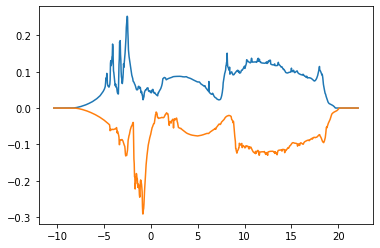

In [9]:
plt.plot(fe_dos.energies, a[0], label = 'up')
plt.plot(fe_dos.energies, a[1], label = 'dw')